In this project, I use the ParTy (Parallel Typology Corpus) dataset developed by Natalia Levshina:

Levshina, Natalia. 2016. Verbs of letting in Germanic and Romance languages: A quantitative investigation based on a parallel corpus of film subtitles. Languages in Contrast 16(1): 84–117.

ParTy is a multilingual parallel corpus constructed from film subtitles. It contains dialogue segments aligned at the sentence level across a wide range of languages. Each film is therefore represented by a set of subtitles in multiple languages. Given the genre of the texts in the corpus, the sentences are typically short and dialogic in nature.

In this project, the dataset is used as the basis for developing a model capable of determining whether two subtitle segments in different languages express the same semantic content. The goal is to build a cross-linguistic textual similarity model between text segments using a Siamese LSTM network.

In the corpus, English serves as the sole source language, while the target languages number 42. However, the number of available films differs across languages. The objective is to perform prediction not for a single language pair, but from English to all available target languages.

Potential applications of the model include the automatic identification of semantically equivalent sentences in large multilingual collections, such as parallel corpora or subtitle datasets in multiple languages.

In [1]:
from pathlib import Path
import zipfile
import shutil
import requests

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [138]:
import matplotlib.pyplot as plt

In [4]:
import re

In [5]:
from tqdm.auto import tqdm

In [6]:
from time import perf_counter

In [7]:
import timeit

In [8]:
import gc

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
from tensorflow.keras.callbacks import Callback

In [146]:
from sklearn.metrics import confusion_matrix, classification_report

In [150]:
from sklearn.metrics import precision_recall_curve

In [11]:
party_data_root = Path('party_data')
party_zip_path = party_data_root.joinpath('party_repository.zip')
party_extract_root = party_data_root.joinpath('extracted_repository')

In [12]:
party_data_root.mkdir(parents = True, exist_ok = True)

In [13]:
party_repository_url = 'https://github.com/levshina/ParTy-1.0/archive/refs/heads/master.zip'

In [14]:
response = requests.get(party_repository_url, stream = True)
response.raise_for_status()

In [15]:
with open(party_zip_path, "wb") as zip_file:
    for chunk in response.iter_content(chunk_size = 1024 * 1024):
        if chunk:
            zip_file.write(chunk)

In [16]:
party_zip_path

PosixPath('party_data/party_repository.zip')

In [17]:
party_extract_root.mkdir(parents=True, exist_ok = True)

In [18]:
with zipfile.ZipFile(party_zip_path, "r") as zip_file:
    zip_file.extractall(party_extract_root)

In [19]:
party_repository_root = next(
    path for path in party_extract_root.iterdir()
    if path.is_dir()
)

In [20]:
party_repository_root

PosixPath('party_data/extracted_repository/ParTy-1.0-master')

In [21]:
movie_directories = [path for path in party_repository_root.iterdir() if path.is_dir()]

In [22]:
movie_directories

[PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/BridgeOfSpies'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/Spectre'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/GrandHotel'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/Noah'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/Frozen'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/DasLebenDerAnderen'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/BlackSwan'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/Inception'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/IronLady'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/ImitationGame'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/Originals'),
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/Avatar'),
 PosixPath('party_data/extracted_repo

In [23]:
len(movie_directories)

14

In [24]:
movie_names = sorted([path.name for path in movie_directories])

In [25]:
print(movie_names)

['Amelie', 'Avatar', 'BlackSwan', 'BridgeOfSpies', 'DasLebenDerAnderen', 'Frozen', 'GoneGirl', 'GrandHotel', 'ImitationGame', 'Inception', 'IronLady', 'Noah', 'Originals', 'Spectre']


In [26]:
for i, t in enumerate(movie_names):
    print(f'{i+1}. {t}')

1. Amelie
2. Avatar
3. BlackSwan
4. BridgeOfSpies
5. DasLebenDerAnderen
6. Frozen
7. GoneGirl
8. GrandHotel
9. ImitationGame
10. Inception
11. IronLady
12. Noah
13. Originals
14. Spectre


In [27]:
sample_movie_directory = movie_directories[0]

In [28]:
sample_movie_directory, list(sample_movie_directory.iterdir())

(PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie'),
 [PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_fin.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_dan.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_ron.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_hun.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_swe.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_est.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_zho.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_fra.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_por.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_bul.txt'),
  PosixPath('party_

__Now let's inspect the structure__

Since the English–Arabic pair appears first in alphabetical order, we will use it as an illustrative example.

In [29]:
sample_txt_file_paths = [file_path for file_path in sample_movie_directory.iterdir() if file_path.is_file() and file_path.suffix == ".txt"]

In [30]:
sample_txt_file_path = sample_txt_file_paths[0]

In [31]:
sample_txt_file_path

PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_fin.txt')

In [32]:
n_lines_to_lookup = 30

with open(sample_txt_file_path, 'r', encoding = 'utf-8', errors = 'replace') as text_file:
    sample_txt_first_lines = [next(text_file) for _ in range(n_lines_to_lookup)]

In [33]:
print(''.join(sample_txt_first_lines))

0	On September 3 , 1973 ... a blue fly capable of flapping 70 beats a minute ... 	3 . syyskuuta 1973 kello 18 . 28 . 32 - Lihakärpänen , joka räpyttää siipiään 14 670 kertaa minuutissa - 
1	landed on St . 	Laskeutui Montmartren Rue St Vincentille . 
2	Vincent Street in Montmartre . 	Laskeutui Montmartren Rue St Vincentille . 
3	At that moment , on a restaurant terrace nearby ... the wind magically made two glasses dance unseen ... on a tablecloth . 	Samalla hetkellä läheisen ravintolan terassilla - tuuli tanssitti kahta lasia pöytäliinalla , kenenkään näkemättä . 
4	Meanwhile , in a 5th- floor flat on Avenue Trudaine , Paris 9 ... returning from his best friend 's funeral ... 	Samaan aikaan 5 . kerroksen asunnossa Avenue Trudainella - parhaan ystävänsä Emil Maginaun hautajaisista - palannut Eugéne Colére pyyhki hänen nimensä osoitekirjastaan . 
5	Eugene Colere erased him from his address book . 	Samaan aikaan 5 . kerroksen asunnossa Avenue Trudainella - parhaan ystävänsä Emil Maginaun 

In [34]:
sample_txt_file_path.name

'Amelie_eng_fin.txt'

In [35]:
with open(sample_txt_file_path, "r", encoding="utf-8", errors = "replace") as subtitle_file:
    subtitle_lines = [line.rstrip("\n") for line in subtitle_file]

In [36]:
subtitle_lines_df = pd.DataFrame({"raw_line": subtitle_lines})

The alignment of subtitle segments across the two languages is not perfectly clean in the files. It is not possible to directly read the data as a two-column CSV using tabulation as a separator. Some preprocessing is required. There may be double tab characters or other typographical inconsistencies.

Since XML files are also provided with the corpus, we will first examine what they contain and then decide how to proceed.

In [37]:
subtitle_lines_df.head(20)

,raw_line
0,"0\tOn September 3 , 1973 ... a blue fly capabl..."
1,1\tlanded on St . \tLaskeutui Montmartren Rue ...
2,2\tVincent Street in Montmartre . \tLaskeutui ...
3,"3\tAt that moment , on a restaurant terrace ne..."
4,"4\tMeanwhile , in a 5th- floor flat on Avenue ..."
5,5\tEugene Colere erased him from his address b...
6,"6\tAt the same moment , a sperm with one X chr..."
7,"7\tNine months later ... \tFouet , munasolua ."
8,8\tAmelie Poulain was born . \tYhdeksän kuukau...
9,9\tAMELIE FROM MONTMARTRE \tAMELIE


Within each film directory, there is an XML folder. Let us take the film Amélie as an example and examine its contents.

In [38]:
sample_movie_directory = party_repository_root.joinpath("Amelie")
sample_movie_xml_directory = sample_movie_directory.joinpath("XML")

In [39]:
sample_movie_xml_directory.exists(), sample_movie_xml_directory

(True,
 PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML'))

In [40]:
xml_entry_paths = sorted(list(sample_movie_xml_directory.iterdir()))

In [41]:
xml_entry_paths[:20], len(xml_entry_paths)

([PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_ara.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_bos.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_bul.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_ces.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_dan.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_deu.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_ell.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_eng.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_est.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_fas.xml'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/XML/Amelie_fin.xml'),

In [42]:
# Open a single XML file for inspection. We select the Italian version.

sample_readable_xml_file_path = sample_movie_xml_directory.joinpath("Amelie_ita.xml")

with open(sample_readable_xml_file_path, "r", encoding="utf-8", errors="replace") as xml_file:
    for _ in range(50):
        print(xml_file.readline().rstrip())

<?xml version="1.0" encoding="utf-8"?>
<document>
  <s id="1">
    <time id="T2S" value="00:00:37,058" />
    <w id="1.1">Il</w>
    <w id="1.2">3</w>
    <w id="1.3">settembre</w>
    <w id="1.4">1973</w>
    <w id="1.5">alle</w>
    <w id="1.6">18</w>
    <w id="1.7">:</w>
    <w id="1.8">28</w>
    <w id="1.9">e</w>
    <w id="1.10">32</w>
    <w id="1.11">secondi</w>
    <time id="T2E" value="00:00:41,587" />
    <time id="T3S" value="00:00:41,630" />
    <w id="1.12">una</w>
    <w id="1.13">mosca</w>
    <w id="1.14">blu</w>
    <w id="1.15">della</w>
    <w id="1.16">famiglia</w>
    <w id="1.17">delle</w>
    <w id="1.18">Calliforidee</w>
    <w id="1.19">,</w>
    <w id="1.20">capace</w>
    <w id="1.21">di</w>
    <w id="1.22">produrre</w>
    <w id="1.23">14</w>
    <w id="1.24">.</w>
    <w id="1.25">670</w>
    <w id="1.26">battiti</w>
    <w id="1.27">d'</w>
    <w id="1.28">ali</w>
    <w id="1.29">al</w>
    <w id="1.30">minuto</w>
    <w id="1.31">,</w>
    <time id="T

Quindi, qua possiamo vedere che ogni file xml è monolingue, con dentro un timestamp, segmenti (\<s>) di testo e una sequenza di parole (\<w>) tokenizzate.

Ai fini del presente progetto scegliamo di usare i dati testuali nei file txt bilingui in quanto più adatti al nostro obiettivo.

Parsiamo uno dei file testo per iniziare.

In [43]:
bilingual_filename_pattern = re.compile(
    r"^(?P<movie>.+)_(?P<source>[a-z]{3})_(?P<target>[a-z]{3})\.txt$",
    re.IGNORECASE
)

In [44]:
def parse_bilingual_subtitle_txt_file(subtitle_txt_file_path):
    filename_match = bilingual_filename_pattern.match(subtitle_txt_file_path.name)
    if filename_match is None:
        raise ValueError(f"nome file non riconosciuto: {subtitle_txt_file_path.name}")

    movie_id = filename_match.group("movie")
    source_language = filename_match.group("source").lower()
    target_language = filename_match.group("target").lower()

    parsed_rows = []
    skipped_line_count = 0

    with open(subtitle_txt_file_path, "r", encoding="utf-8", errors="replace") as subtitle_file:
        for raw_line in subtitle_file:
            stripped_line = raw_line.rstrip("\n")
            if not stripped_line.strip():
                continue

            fields = stripped_line.split("\t", maxsplit=2)
            if len(fields) < 3:
                skipped_line_count += 1
                continue

            segment_id_text = fields[0].strip()
            if not segment_id_text.isdigit():
                skipped_line_count += 1
                continue

            parsed_rows.append({
                "movie_id": movie_id,
                "source_language": source_language,
                "target_language": target_language,
                "segment_id": int(segment_id_text),
                "text_source": fields[1].strip(),
                "text_target": fields[2].strip(),
            })

    subtitle_pairs_df = pd.DataFrame(parsed_rows)
    return subtitle_pairs_df, skipped_line_count

In [45]:
amelie_eng_ita_path = party_repository_root.joinpath("Amelie").joinpath("Amelie_eng_ita.txt")

In [46]:
subtitle_pairs_df, skipped_line_count = parse_bilingual_subtitle_txt_file(amelie_eng_ita_path)

In [47]:
subtitle_pairs_df.head(10), skipped_line_count, subtitle_pairs_df.shape

(  movie_id source_language target_language  segment_id  \
 0   Amelie             eng             ita           0   
 1   Amelie             eng             ita           1   
 2   Amelie             eng             ita           2   
 3   Amelie             eng             ita           3   
 4   Amelie             eng             ita           4   
 5   Amelie             eng             ita           5   
 6   Amelie             eng             ita           6   
 7   Amelie             eng             ita           7   
 8   Amelie             eng             ita           8   
 9   Amelie             eng             ita           9   
 
                                          text_source  \
 0  On September 3 , 1973 ... a blue fly capable o...   
 1                                     landed on St .   
 2                     Vincent Street in Montmartre .   
 3  At that moment , on a restaurant terrace nearb...   
 4  Meanwhile , in a 5th- floor flat on Avenue Tru...   
 5   Eu

In [48]:
subtitle_pairs_df.head()

,movie_id,source_language,target_language,segment_id,text_source,text_target
0,Amelie,eng,ita,0,"On September 3 , 1973 ... a blue fly capable o...",Il 3 settembre 1973 alle 18 : 28 e 32 secondi ...
1,Amelie,eng,ita,1,landed on St .,Il 3 settembre 1973 alle 18 : 28 e 32 secondi ...
2,Amelie,eng,ita,2,Vincent Street in Montmartre .,"Vincent , a Montmartre ."
3,Amelie,eng,ita,3,"At that moment , on a restaurant terrace nearb...","In quell' istante , sulla terrazza di un risto..."
4,Amelie,eng,ita,4,"Meanwhile , in a 5th- floor flat on Avenue Tru...","In quell' istante , al quinto piano del 28 di ..."


We have split each line of text in English and Italian, apparently successfully, using one film and the English–Italian language pair as an example.

Now we will apply the same procedure to all films and collect everything into a DataFrame.

First, we will index all files corresponding to the English–Italian language pair.

In [49]:
subtitle_filename_pattern = re.compile(
    r"^(?P<movie>.+)_(?P<src>[a-z]{3})_(?P<tgt>[a-z]{3})\.txt$",
    re.IGNORECASE
)

In [50]:
def collect_bilingual_txt_paths(party_repository_root, source_language="eng", target_language="ita"):
    bilingual_txt_paths = []
    for movie_directory in party_repository_root.iterdir():
        if not movie_directory.is_dir():
            continue

        for file_path in movie_directory.iterdir():
            if not (file_path.is_file() and file_path.suffix.lower() == ".txt"):
                continue

            match = subtitle_filename_pattern.match(file_path.name)
            if match is None:
                continue

            if match.group("src").lower() == source_language and match.group("tgt").lower() == target_language:
                bilingual_txt_paths.append(file_path)

    return sorted(bilingual_txt_paths)

In [51]:
eng_ita_txt_paths = collect_bilingual_txt_paths(
    party_repository_root,
    source_language="eng",
    target_language="ita"
)

In [52]:
len(eng_ita_txt_paths), eng_ita_txt_paths

(5,
 [PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_ita.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/BlackSwan/BlackSwan_eng_ita.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Frozen/Frozen_eng_ita.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Inception/Inception_eng_ita.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Noah/Noah_eng_ita.txt')])

Ci sono solo 5 film eng-ita, allora vediamo le altre lingue.

In [53]:
subtitle_filename_pattern = re.compile(
    r"^(?P<movie>.+)_(?P<src>[a-z]{3})_(?P<tgt>[a-z]{3})\.txt$",
    re.IGNORECASE
)

In [54]:
def collect_all_eng_txt_paths(party_repository_root):
    eng_txt_paths = []
    for movie_directory in party_repository_root.iterdir():
        if not movie_directory.is_dir():
            continue
        for file_path in movie_directory.iterdir():
            if not (file_path.is_file() and file_path.suffix.lower() == ".txt"):
                continue
            match = subtitle_filename_pattern.match(file_path.name)
            if match and match.group("src").lower() == "eng":
                eng_txt_paths.append(file_path)
    return sorted(eng_txt_paths)

In [55]:
eng_all_txt_paths = collect_all_eng_txt_paths(party_repository_root)

In [56]:
len(eng_all_txt_paths), eng_all_txt_paths

(260,
 [PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_ara.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_bos.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_bul.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_ces.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_dan.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_deu.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_ell.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_est.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_fas.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_fin.txt'),
  PosixPath('party_data/extracted_repository/ParTy-1.0-master/Amelie/Amelie_eng_fra.

Parse all files and concatenate the results

In [57]:
all_pairs_dfs = []

In [58]:
total_skipped_lines = 0

for txt_file_path in eng_all_txt_paths:
    subtitle_pairs_df, skipped_line_count = parse_bilingual_subtitle_txt_file(txt_file_path)
    all_pairs_dfs.append(subtitle_pairs_df)
    total_skipped_lines += skipped_line_count

In [59]:
full_subtitle_pairs_df = pd.concat(all_pairs_dfs, ignore_index = True)

In [60]:
full_subtitle_pairs_df.shape, full_subtitle_pairs_df["target_language"].nunique(), total_skipped_lines

((414954, 6), 42, 30)

There are 42 target languages, 30 discarded rows, and a total of 414,954 source–target language entries.

In [61]:
full_subtitle_pairs_df.columns

Index(['movie_id', 'source_language', 'target_language', 'segment_id',
       'text_source', 'text_target'],
      dtype='object')

In [62]:
full_subtitle_pairs_df['source_language'].value_counts()

,count
source_language,
eng,414954


In [63]:
full_subtitle_pairs_df['target_language'].value_counts()

,count
target_language,
fin,21403
deu,21403
swe,21403
fra,21402
pol,21402
rus,20055
nld,20053
spa,20045
ron,18696


In [64]:
len(full_subtitle_pairs_df['target_language'].unique())

42

In [65]:
def build_similarity_pairs_multilingual(
    full_subtitle_pairs_df: pd.DataFrame,
    negatives_intra_movie: int = 1,
    negatives_cross_movie: int = 1,
    random_seed: int = 42,
    max_rows: int | None = None
) -> pd.DataFrame:
    rng = np.random.default_rng(random_seed)

    usable_pairs_df = full_subtitle_pairs_df[
        full_subtitle_pairs_df["text_source"].astype(str).str.strip().ne("") &
        full_subtitle_pairs_df["text_target"].astype(str).str.strip().ne("")
    ].reset_index(drop=True)

    if max_rows is not None:
        usable_pairs_df = usable_pairs_df.sample(n=max_rows, random_state=random_seed).reset_index(drop=True)

    # Precompute index arrays grouped by target language for efficient access
    lang_to_indices = {
        lang: usable_pairs_df.index[usable_pairs_df["target_language"].eq(lang)].to_numpy()
        for lang in usable_pairs_df["target_language"].unique()
    }

    # Precompute language+movie indices (negatives sampled within the same movie)
    lang_movie_to_indices = {}
    for lang in usable_pairs_df["target_language"].unique():
        lang_df = usable_pairs_df[usable_pairs_df["target_language"].eq(lang)]
        for movie_id, movie_df in lang_df.groupby("movie_id"):
            lang_movie_to_indices[(lang, movie_id)] = movie_df.index.to_numpy()

    similarity_records = []

    for row_index, row in tqdm(usable_pairs_df.iterrows(), total=len(usable_pairs_df), desc = "building similarity pairs"):
        movie_id = row["movie_id"]
        lang = row["target_language"]
        segment_id = row["segment_id"]

        # positive
        similarity_records.append({
            "movie_id": movie_id,
            "target_language": lang,
            "segment_id_source": int(segment_id),
            "segment_id_target": int(segment_id),
            "text_source": row["text_source"],
            "text_target": row["text_target"],
            "label": 1
        })

        # Negative samples within the same movie (same language)
        intra_candidates = lang_movie_to_indices.get((lang, movie_id), np.array([], dtype=int))
        if intra_candidates.size > 1:
            intra_candidates = intra_candidates[usable_pairs_df.loc[intra_candidates, "segment_id"].ne(segment_id).to_numpy()]

        for _ in range(negatives_intra_movie):
            if intra_candidates.size == 0:
                break
            neg_idx = int(rng.choice(intra_candidates))
            similarity_records.append({
                "movie_id": movie_id,
                "target_language": lang,
                "segment_id_source": int(segment_id),
                "segment_id_target": int(usable_pairs_df.at[neg_idx, "segment_id"]),
                "text_source": row["text_source"],
                "text_target": usable_pairs_df.at[neg_idx, "text_target"],
                "label": 0
            })

        # Negative samples across different movies (same language)
        lang_candidates = lang_to_indices[lang]
        if lang_candidates.size > 1:
            cross_candidates = lang_candidates[usable_pairs_df.loc[lang_candidates, "movie_id"].ne(movie_id).to_numpy()]
        else:
            cross_candidates = np.array([], dtype=int)

        for _ in range(negatives_cross_movie):
            if cross_candidates.size == 0:
                break
            neg_idx = int(rng.choice(cross_candidates))
            similarity_records.append({
                "movie_id": movie_id,
                "target_language": lang,
                "segment_id_source": int(segment_id),
                "segment_id_target": int(usable_pairs_df.at[neg_idx, "segment_id"]),
                "text_source": row["text_source"],
                "text_target": usable_pairs_df.at[neg_idx, "text_target"],
                "label": 0
            })

    similarity_pairs_df = pd.DataFrame(similarity_records)
    similarity_pairs_df = similarity_pairs_df.sample(frac=1, random_state=random_seed).reset_index(drop = True)
    return similarity_pairs_df

In [66]:
class timer:
    def __init__(self, label: str):
        self.label = label
        self.start = None

    def __enter__(self):
        self.start = perf_counter()
        return self

    def __exit__(self, exc_type, exc, tb):
        elapsed = perf_counter() - self.start
        print(f"{self.label}: {elapsed:.2f} s")

In [67]:
with timer("build similarity_pairs_df FULL DATASET"):
    similarity_pairs_df = build_similarity_pairs_multilingual(
        full_subtitle_pairs_df=full_subtitle_pairs_df,
        negatives_intra_movie = 1,
        negatives_cross_movie = 1,
        random_seed = 42,
        max_rows = None
    )

building similarity pairs:   0%|          | 0/364482 [00:00<?, ?it/s]

build similarity_pairs_df FULL DATASET: 1113.63 s


In [102]:
#full_subtitle_pairs_df.to_excel('full_subtitle_pairs.xlsx')

In [97]:
del full_subtitle_pairs_df

In [103]:
gc.collect()

0

In [104]:
similarity_pairs_df.shape

(1088136, 7)

In [105]:
# backup
similarity_pairs_df.to_parquet(
    "similarity_pairs_df.parquet",
    index = False,
    compression = "snappy"
)

In [106]:
similarity_pairs_df["label"].value_counts()

,count
label,
0,723654
1,364482


In [107]:
similarity_pairs_df["target_language"].nunique()

42

In [108]:
def split_by_movie(similarity_pairs_df, train_ratio = 0.8, val_ratio = 0.1, random_seed = 42):
    rng = np.random.default_rng(random_seed)

    movie_ids = similarity_pairs_df["movie_id"].unique()
    rng.shuffle(movie_ids)

    num_movies = len(movie_ids)
    train_cut = int(num_movies * train_ratio)
    val_cut = int(num_movies * (train_ratio + val_ratio))

    train_movies = set(movie_ids[:train_cut])
    val_movies = set(movie_ids[train_cut:val_cut])
    test_movies = set(movie_ids[val_cut:])

    train_pairs_df = similarity_pairs_df[similarity_pairs_df["movie_id"].isin(train_movies)].reset_index(drop=True)
    val_pairs_df = similarity_pairs_df[similarity_pairs_df["movie_id"].isin(val_movies)].reset_index(drop=True)
    test_pairs_df = similarity_pairs_df[similarity_pairs_df["movie_id"].isin(test_movies)].reset_index(drop=True)

    return train_pairs_df, val_pairs_df, test_pairs_df

In [109]:
with timer("split train/val/test by movie"):
    train_pairs_df, val_pairs_df, test_pairs_df = split_by_movie(
        similarity_pairs_df,
        train_ratio=0.8,
        val_ratio=0.1,
        random_seed=42
    )

split train/val/test by movie: 0.41 s


In [110]:
train_pairs_df.shape, val_pairs_df.shape, test_pairs_df.shape

((806562, 7), (70806, 7), (210768, 7))

In [111]:
# How many films are there in each split?
train_pairs_df["movie_id"].nunique(), val_pairs_df["movie_id"].nunique(), test_pairs_df["movie_id"].nunique()

(10, 1, 2)

In [112]:
# Normalized label distribution in each split
train_pairs_df["label"].value_counts(normalize = True), val_pairs_df["label"].value_counts(normalize = True), test_pairs_df["label"].value_counts(normalize = True)

(label
 0    0.665646
 1    0.334354
 Name: proportion, dtype: float64,
 label
 0    0.66411
 1    0.33589
 Name: proportion, dtype: float64,
 label
 0    0.663032
 1    0.336968
 Name: proportion, dtype: float64)

In [113]:
# backup splits
#
with timer('save splits parquet'):
    train_pairs_df.to_parquet('train_pairs_df.parquet', index = False, compression = "snappy")
    val_pairs_df.to_parquet('val_pairs_df.parquet', index = False, compression = "snappy")
    test_pairs_df.to_parquet('test_pairs_df.parquet', index = False, compression = "snappy")

save splits parquet: 1.01 s


__Char-level TextVectorization__

Word-level tokenization would require a separate pipeline for each language; therefore, character-level vectorization is adopted.

In [116]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [117]:
max_char_length = 250
max_char_vocab_size = 200

In [118]:
char_vectorizer = layers.TextVectorization(
    standardize="lower",
    split="character",
    output_mode="int",
    output_sequence_length=max_char_length,
    max_tokens=max_char_vocab_size
)

In [119]:
with timer("char_vectorizer.adapt"):
    train_source_text = tf.constant(train_pairs_df["text_source"].astype(str).values)
    train_target_text = tf.constant(train_pairs_df["text_target"].astype(str).values)

    train_text_for_vocab = tf.data.Dataset.from_tensor_slices(
        tf.concat([train_source_text, train_target_text], axis=0)
    )
    char_vectorizer.adapt(train_text_for_vocab.batch(2048))

char_vectorizer.adapt: 20.78 s


In [120]:
char_vocab_size = len(char_vectorizer.get_vocabulary())

In [121]:
char_vocab_size

200

In [122]:
def make_tf_dataset(pairs_df, batch_size = 256, shuffle = True):
    source_text = tf.constant(pairs_df["text_source"].astype(str).values)
    target_text = tf.constant(pairs_df["text_target"].astype(str).values)
    labels = tf.constant(pairs_df["label"].astype(int).values)

    source_ids = char_vectorizer(source_text)
    target_ids = char_vectorizer(target_text)

    ds = tf.data.Dataset.from_tensor_slices(((source_ids, target_ids), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(pairs_df), 20000), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [123]:
with timer("build tf.data datasets"):
    train_ds = make_tf_dataset(train_pairs_df, batch_size = 256, shuffle = True)
    val_ds = make_tf_dataset(val_pairs_df, batch_size = 256, shuffle = False)
    test_ds = make_tf_dataset(test_pairs_df, batch_size = 256, shuffle = False)

build tf.data datasets: 28.74 s


In [124]:
for (source_batch, target_batch), label_batch in train_ds.take(1):
    print(source_batch.shape, target_batch.shape, label_batch.shape)

(256, 250) (256, 250) (256,)


__Siamese BiLSTM__

In [125]:
embedding_dim = 64
lstm_units = 64

In [126]:
def build_shared_encoder(char_vocab_size, max_char_length, embedding_dim, lstm_units):
    text_input = keras.Input(shape=(max_char_length,), dtype="int32", name="text_ids")

    x = layers.Embedding(
        input_dim=char_vocab_size,
        output_dim=embedding_dim,
        mask_zero=True,
        name="char_embedding"
    )(text_input)

    x = layers.Bidirectional(
        layers.LSTM(lstm_units, name="lstm"),
        name="bilstm"
    )(x)

    encoder_model = keras.Model(text_input, x, name="shared_encoder")
    return encoder_model

In [127]:
shared_encoder = build_shared_encoder(
    char_vocab_size=char_vocab_size,
    max_char_length=max_char_length,
    embedding_dim=embedding_dim,
    lstm_units=lstm_units
)

In [128]:
source_input = keras.Input(shape=(max_char_length,), dtype="int32", name="source_ids")
target_input = keras.Input(shape=(max_char_length,), dtype="int32", name="target_ids")

source_vec = shared_encoder(source_input)
target_vec = shared_encoder(target_input)

abs_diff = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), name="abs_diff")([source_vec, target_vec])

mult = layers.Multiply(name="elementwise_product")([source_vec, target_vec])

combined = layers.Concatenate(name="combine_features")([abs_diff, mult])
combined = layers.Dense(128, activation="relu", name="dense_128")(combined)
combined = layers.Dropout(0.2, name="dropout_02")(combined)

output = layers.Dense(1, activation="sigmoid", name="similarity")(combined)

In [129]:
siamese_lstm_model = keras.Model(
    inputs=[source_input, target_input],
    outputs=output,
    name="siamese_bilstm_similarity"
)

In [130]:
siamese_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="auc")]
)

In [131]:
siamese_lstm_model.summary()

Model: "siamese_bilstm_similarity"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ source_ids          │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_ids          │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_encoder      │ (None, 128)       │     78,848 │ source_ids[0][0], │
│ (Functional)        │                   │            │ target_ids[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abs_diff (Lambda)   │ (None, 128)       │          0 │ shared_encoder[0… │
│                     │                   │            │ shared_encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elementwise_product │ (None, 128)       │          0 │ shared_encoder[0… │
│ (Multiply)          │                   │            │ shared_encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_features    │ (None, 256)       │          0 │ abs_diff[0][0],   │
│ (Concatenate)       │                   │            │ elementwise_prod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 128)       │     32,896 │ combine_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_02          │ (None, 128)       │          0 │ dense_128[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity (Dense)  │ (None, 1)         │        129 │ dropout_02[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,873 (437.00 KB)

 Trainable params: 111,873 (437.00 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
class TqdmProgressCallback(Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params["epochs"]
        self.steps_per_epoch = self.params["steps"]
        self.epoch_bar = tqdm(total=self.epochs, desc="epochs", position=0)

    def on_epoch_begin(self, epoch, logs=None):
        self.batch_bar = tqdm(
            total=self.steps_per_epoch,
            desc=f"epoch {epoch+1}",
            position=1,
            leave=False
        )

    def on_train_batch_end(self, batch, logs=None):
        self.batch_bar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.batch_bar.close()
        self.epoch_bar.update(1)

    def on_train_end(self, logs=None):
        self.epoch_bar.close()

In [133]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_auc",
    mode = "max",
    patience = 2,
    restore_best_weights = True
)

In [134]:
with timer("training siamese_lstm_model"):
    history = siamese_lstm_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=[
            early_stopping,
            TqdmProgressCallback()
        ],
        verbose = 0  # otherwise it conflicts with tqdm...
    )

epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/3151 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/3151 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/3151 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/3151 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/3151 [00:00<?, ?it/s]

training siamese_lstm_model: 640.81 s


In [135]:
import json
with open("history.json", "w") as f:
    json.dump(history.history, f)

In [136]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history.csv", index=False)

In [137]:
siamese_lstm_model.save("siamese_lstm_model.keras")

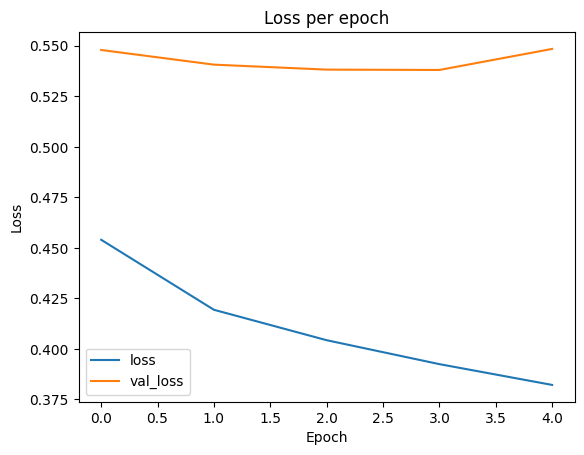

In [139]:
for metric in [c for c in history_df.columns if c.startswith("val_")]:
    pass  # solo per vedere cosa c'è

plt.figure()
if "loss" in history_df:
    plt.plot(history_df["loss"], label="loss")
if "val_loss" in history_df:
    plt.plot(history_df["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

The model shows slight overfitting.

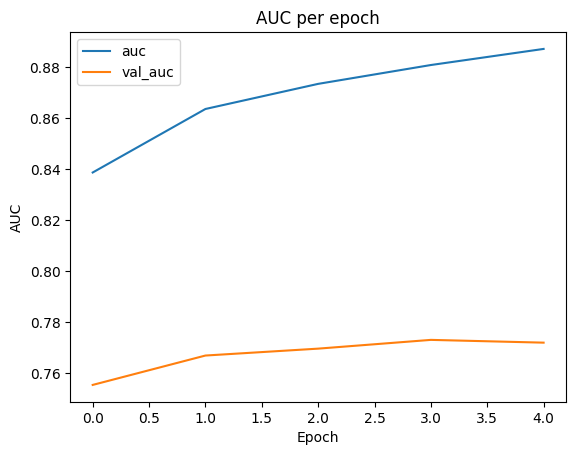

In [140]:
plt.figure()
if "auc" in history_df:
    plt.plot(history_df["auc"], label="auc")
if "val_auc" in history_df:
    plt.plot(history_df["val_auc"], label="val_auc")
plt.legend()
plt.title("AUC per epoch")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

In [143]:
history.history.keys(), {k: history.history[k][-1] for k in history.history}

(dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss']),
 {'accuracy': 0.8340139985084534,
  'auc': 0.8871098756790161,
  'loss': 0.38214972615242004,
  'val_accuracy': 0.7605852484703064,
  'val_auc': 0.771891713142395,
  'val_loss': 0.5484454035758972})

In [144]:
with timer("evaluate on test"):
    test_metrics = siamese_lstm_model.evaluate(test_ds, return_dict=True)

test_metrics

824/824 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.8159 - auc: 0.8588 - loss: 0.4215
evaluate on test: 12.76 s


{'accuracy': 0.815365731716156,
 'auc': 0.859073281288147,
 'loss': 0.42120346426963806}

In [145]:
y_true_list = []
y_score_list = []

for (source_ids_batch, target_ids_batch), label_batch in test_ds:
    score_batch = siamese_lstm_model.predict(
        [source_ids_batch, target_ids_batch],
        verbose=0
    ).ravel()
    y_true_list.append(label_batch.numpy())
    y_score_list.append(score_batch)

y_true = np.concatenate(y_true_list)
y_score = np.concatenate(y_score_list)

In [147]:
threshold = 0.5
y_pred = (y_score >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)

In [148]:
cm

array([[128070,  11676],
       [ 27239,  43783]])

In [149]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8246    0.9164    0.8681    139746
           1     0.7895    0.6165    0.6923     71022

    accuracy                         0.8154    210768
   macro avg     0.8070    0.7665    0.7802    210768
weighted avg     0.8128    0.8154    0.8089    210768



**Test set** (210,768 examples):

Accuracy = 0.8154
AUC = 0.8591
Loss = 0.4212

An AUC of 0.859 indicates good discriminative ability.

The accuracy of 0.815 is consistent with the class imbalance, as negative examples outnumber positive ones.

**Class 0** (non-match)

Precision = 0.8246
Recall = 0.9164
F1 = 0.8681

The model performs well in identifying non-matches, as reflected by the high recall.

**Class 1** (match)

Precision = 0.7895
Recall = 0.6165
F1 = 0.6923

When the model predicts a match, it is generally reliable (reasonably high precision), but it misses a portion of true matches (lower recall).

Therefore, we now select the optimal decision threshold:

In [151]:
precision, recall, thresholds = precision_recall_curve(y_true, y_score)
f1 = (2 * precision * recall) / (precision + recall + 1e-12)

best_idx = int(np.nanargmax(f1))
best_threshold = thresholds[max(best_idx - 1, 0)]

In [152]:
best_threshold

np.float32(0.34776363)

Repeat the evaluation with the updated threshold

In [153]:
y_pred_best = (y_score >= best_threshold).astype(int)
print("best_threshold =", best_threshold)
print(classification_report(y_true, y_pred_best, digits=4))

best_threshold = 0.34776363
              precision    recall  f1-score   support

           0     0.8598    0.8287    0.8440    139746
           1     0.6853    0.7341    0.7089     71022

    accuracy                         0.7968    210768
   macro avg     0.7726    0.7814    0.7764    210768
weighted avg     0.8010    0.7968    0.7984    210768



The results improved with the updated threshold.

The recall for Class 1 has increased.
The precision for Class 1 has decreased slightly, but remains acceptable.
The F1 score for Class 1 has improved.

In [155]:
with open("best_threshold.txt", "w") as f:
    f.write(str(best_threshold))

In [156]:
test_pairs_with_scores_df = test_pairs_df.copy()
test_pairs_with_scores_df["score"] = y_score
test_pairs_with_scores_df["pred"] = (test_pairs_with_scores_df["score"] >= best_threshold).astype(int)

In [157]:
test_pairs_with_scores_df.head()

,movie_id,target_language,segment_id_source,segment_id_target,text_source,text_target,label,score,pred
0,Avatar,ron,1643,1643,Go !,Hai !,1,0.713812,1
1,Avatar,lav,774,514,Thank you .,Kā viņi zinās ka mēs esam šeit ?,0,0.217694,0
2,Avatar,bul,1022,1022,I really hope this tree-hugger crap is n't on ...,Дано тия еко-простотии не са на матурата .,1,0.838045,1
3,Avatar,por,1684,1436,Trauma kit !,A fabricarem esta guera para terem o que querem .,0,0.059520,0
4,Avatar,swe,988,564,Navi .,Vi tar några av de här monitorerna och en jord...,0,0.031469,0


In [158]:
test_pairs_with_scores_df.to_parquet("test_pairs_with_scores.parquet")

In [159]:
test_pairs_with_scores_df.shape

(210768, 9)

In [161]:
test_metrics

{'accuracy': 0.815365731716156,
 'auc': 0.859073281288147,
 'loss': 0.42120346426963806}

In [162]:
with open("test_metrics.json", "w", encoding="utf-8") as f:
    json.dump(test_metrics, f, indent = 2)

In [164]:
history

In [165]:
with open("training_history.json", "w", encoding="utf-8") as f:
    json.dump(history.history, f, indent=2)

In [167]:
from google.colab import files

files.download("siamese_lstm_model.keras")
files.download("test_metrics.json")
files.download("training_history.json")
files.download("best_threshold.txt")
files.download("test_pairs_with_scores.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>